In [1]:
import io
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm, trange

from flygym import Fly, Camera, SingleFlySimulation
from flygym.examples.cpg_controller import CPGNetwork, PreprogrammedSteps
from flygym.preprogrammed import all_leg_dofs

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
# Initialize the simulation
run_time = 1
enable_adhesion = True

fly = Fly(
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_force=20,
    actuated_joints=all_leg_dofs,
    spawn_pos=(0.0, 0.0, 0.5),
)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right_top_zoomout",
    fps=30,
    play_speed=0.1,
    window_size=(700, 560),
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=1e-4,
)

num_steps_base = int(run_time / sim.timestep)

In [4]:
# Initilize the cpn network
start_ampl = np.ones(6) * 0.2

intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.diff(np.mgrid[:6, :6], axis=0)[0] % 2 * np.pi
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

preprogrammed_steps = PreprogrammedSteps()

cpg_network = CPGNetwork(
    timestep=sim.timestep,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=start_ampl,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=0,
)

# Simulation

In [5]:
n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
obs, info = sim.reset()

# Initalize storage
obs_list = []
phases = np.zeros((num_steps, cpg_network.num_cpgs))
amplitudes = np.zeros((num_steps, cpg_network.num_cpgs))

joint_angles = np.zeros((num_steps, len(fly.actuated_joints)))

for i in trange(num_steps):
    cpg_network.step()

    phases[i] = cpg_network.curr_phases
    amplitudes[i] = cpg_network.curr_magnitudes

    if i == n_stabilisation_steps:
        cpg_network.intrinsic_amps = intrinsic_amps

    joints_angles = []
    adhesion_onoff = []

    for j, leg in enumerate(preprogrammed_steps.legs):
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg,
            cpg_network.curr_phases[j] * (i > n_stabilisation_steps),
            cpg_network.curr_magnitudes[j],
        )
        joints_angles.append(my_joints_angles)
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[j]
        )
        adhesion_onoff.append(my_adhesion_onoff)

    action = {
        "joints": np.concatenate(joints_angles),
        "adhesion": np.array(adhesion_onoff),
    }

    obs, reward, terminated, truncated, info = sim.step(action)
    obs_list.append(obs)
    sim.render()

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [00:18<00:00, 632.23it/s]


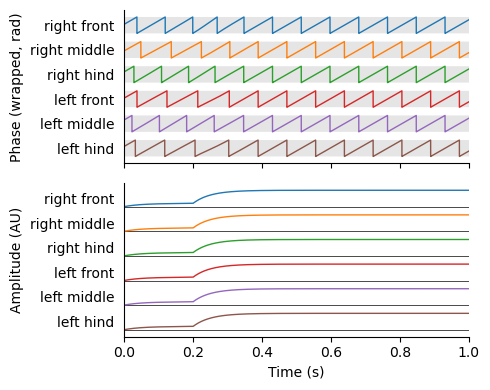

In [6]:
timestep = sim.timestep
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
rule_labels = ["Retraction", "Stumbling"]
leg_basey_lookup = {
    "right front": 0,
    "right middle": -1,
    "right hind": -2,
    "left front": -3,
    "left middle": -4,
    "left hind": -5,
}
leg_name_lookup = {
    "RF": "right front",
    "LF": "left front",
    "RM": "right middle",
    "LM": "left middle",
    "RH": "right hind",
    "LH": "left hind",
}
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}

time = timestep * np.arange(len(phases))


def plot_frame(current_time=None, video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 2), tight_layout=True)
    else:
        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4), tight_layout=True)

    # phase plot
    ax = axs.flatten()[0]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        phase_ts = np.mod(phases[:, i], np.pi * 2)
        ax.plot(
            time,
            phase_ts + leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.fill_between(
            time,
            leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            leg_basey_lookup[leg_name] * np.pi * 3 + np.pi,
            facecolor="gray",
            edgecolor="none",
            alpha=0.2,
            zorder=-1,
            linewidth=1,
        )
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * np.pi * 3)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Phase (wrapped, rad)")

    # amplitude plot
    ax = axs.flatten()[1]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        amp_ts = amplitudes[:, i]
        ax.plot(
            time,
            amp_ts + leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.axhline(
            leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    if video_layout:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 1.5)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Amplitude (AU)")
    ax.set_xlabel("Time (s)")

    sns.despine()
    return fig


plt.style.use("default")
fig = plot_frame()
fig.savefig("outputs/cpg.pdf", transparent=True)

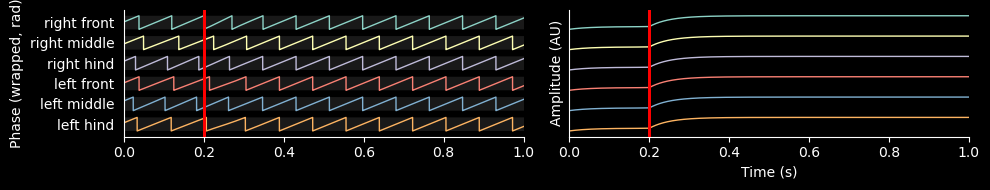

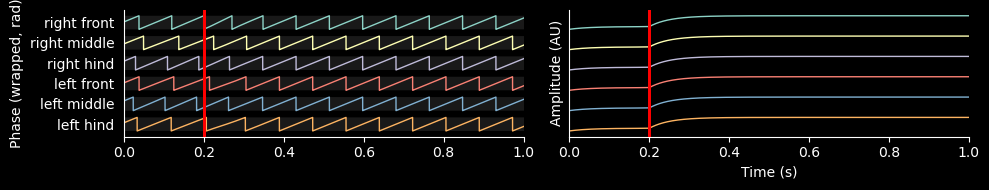

In [7]:
plt.style.use("dark_background")
plot_frame(current_time=0.2, video_layout=True)

In [8]:
def matplotlib_figure_to_array(fig):
    """Adapted from https://stackoverflow.com/a/67823421/13560623"""
    with io.BytesIO() as buff:
        fig.savefig(buff, format="raw")
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    return data.reshape((int(h), int(w), -1))

In [9]:
def merge_frame_and_time_series(i, frame):
    current_time = i * cam._eff_render_interval
    time_series_fig = plot_frame(current_time, video_layout=True)
    time_series_img = matplotlib_figure_to_array(time_series_fig)
    plt.close(fig=time_series_fig)

    assert frame.shape[0] >= time_series_img.shape[0]

    width = frame.shape[1]
    ts_height = int(width * time_series_img.shape[0] / time_series_img.shape[1])
    time_series_img = cv2.resize(time_series_img, (width, ts_height))
    merged_frame = np.concatenate([frame[:, :, :3], time_series_img[:, :, :3]], axis=0)
    return merged_frame

In [10]:
frames_to_render = cam._frames[: int(1 / cam._eff_render_interval)]
video_shape = merge_frame_and_time_series(0, frames_to_render[0]).shape

video_writer = imageio.get_writer("outputs/cpg.mp4", fps=cam.fps)

for i, frame in tqdm(enumerate(frames_to_render), total=len(frames_to_render)):
    merged_frame = merge_frame_and_time_series(i, frame)
    video_writer.append_data(merged_frame)

video_writer.close()

100%|██████████| 300/300 [00:20<00:00, 14.63it/s]
